PKLot ORIGINAL root: /home/rameyjm7/workspace/Computer Vision ECE5554/parking-detector-lpr/data/pklot/PKLot/PKLot


,campus,weather,date,images,annotations,total_occupied_spaces,total_free_spaces
0,PUCPR,Cloudy,2012-09-12,51,51,3195,1905
1,PUCPR,Cloudy,2012-09-16,145,145,9114,5386
2,PUCPR,Cloudy,2012-09-28,132,132,9158,4042
3,PUCPR,Cloudy,2012-10-05,10,10,898,102
4,PUCPR,Cloudy,2012-10-12,154,154,2,15398


Total entries: 144

=== Total Scene Images ===
12417

=== Total Parking Spaces ===
Occupied: 335777
Free: 383751


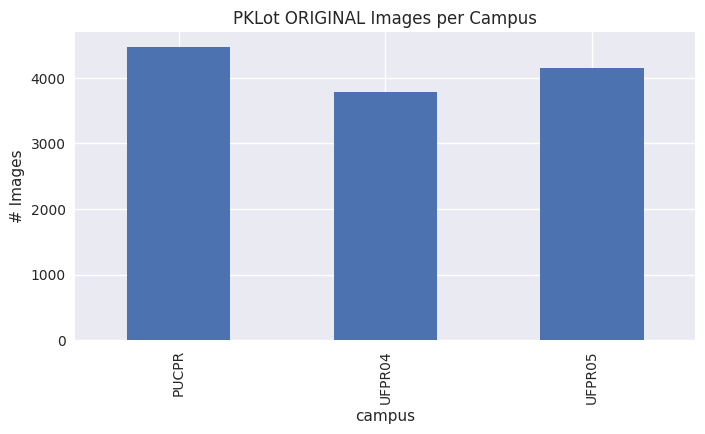

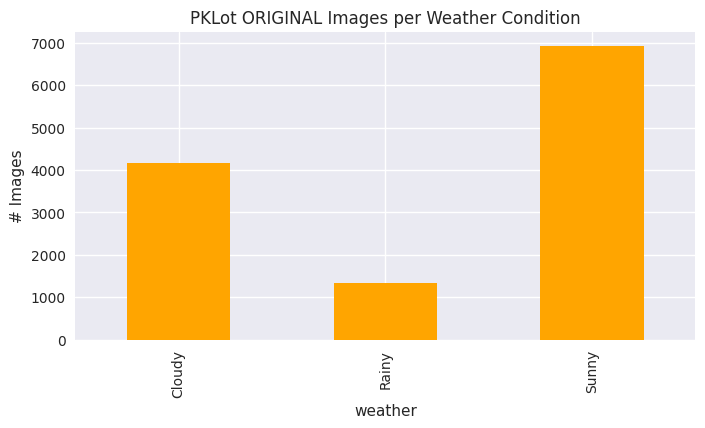

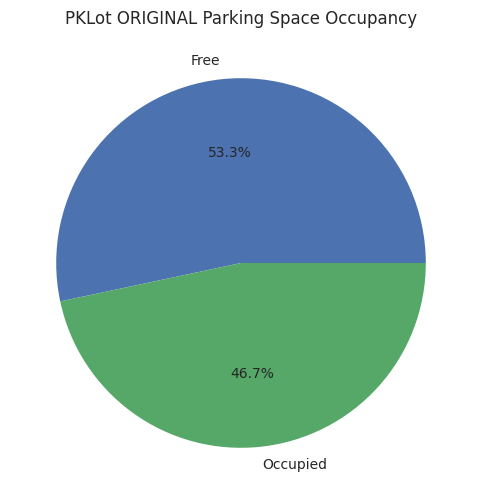

In [4]:
# ============================================================
# PKLot ORIGINAL EDA (full scene images + XML annotations)
# ============================================================

import os
from pathlib import Path
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

BASE_DIR = Path.cwd().parents[0]
PKLOT_ORIG = BASE_DIR / "data" / "pklot" / "PKLot" / "PKLot"

print("PKLot ORIGINAL root:", PKLOT_ORIG)

campuses = ["PUCPR", "UFPR04", "UFPR05"]
weathers = ["Cloudy", "Rainy", "Sunny"]

records = []

def parse_xml(xml_path: Path):
    """Parse PKLot XML (one file per scene image)."""
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
    except:
        return 0, 0

    occ = 0
    free = 0

    for space in root.findall(".//space"):
        status = space.get("occupied")  # "0" or "1"
        if status == "1":
            occ += 1
        else:
            free += 1

    return occ, free


for campus in campuses:
    for weather in weathers:
        weather_dir = PKLOT_ORIG / campus / weather
        if not weather_dir.exists():
            continue

        # DATE folders
        for date_folder in sorted([d for d in weather_dir.iterdir() if d.is_dir()]):
            jpgs = list(date_folder.glob("*.jpg"))
            xmls = list(date_folder.glob("*.xml"))

            total_occ = 0
            total_free = 0

            for xml_file in xmls:
                occ, free = parse_xml(xml_file)
                total_occ += occ
                total_free += free

            records.append({
                "campus": campus,
                "weather": weather,
                "date": date_folder.name,
                "images": len(jpgs),
                "annotations": len(xmls),
                "total_occupied_spaces": total_occ,
                "total_free_spaces": total_free,
            })

df = pd.DataFrame(records)
display(df.head())
print("Total entries:", len(df))

# ------------------------------------------------------------
# Summary
# ------------------------------------------------------------
print("\n=== Total Scene Images ===")
print(df["images"].sum())

print("\n=== Total Parking Spaces ===")
print("Occupied:", df["total_occupied_spaces"].sum())
print("Free:", df["total_free_spaces"].sum())

# ------------------------------------------------------------
# Plot: Images per campus
# ------------------------------------------------------------
df.groupby("campus")["images"].sum().plot(kind="bar", figsize=(8,4))
plt.title("PKLot ORIGINAL Images per Campus")
plt.ylabel("# Images")
plt.show()

# ------------------------------------------------------------
# Plot: Weather distribution
# ------------------------------------------------------------
df.groupby("weather")["images"].sum().plot(kind="bar", figsize=(8,4), color="orange")
plt.title("PKLot ORIGINAL Images per Weather Condition")
plt.ylabel("# Images")
plt.show()

# ------------------------------------------------------------
# Plot: Occupancy distribution
# ------------------------------------------------------------
occ_total = df["total_occupied_spaces"].sum()
free_total = df["total_free_spaces"].sum()

plt.figure(figsize=(6,6))
plt.pie([free_total, occ_total], labels=["Free", "Occupied"], autopct="%1.1f%%")
plt.title("PKLot ORIGINAL Parking Space Occupancy")
plt.show()


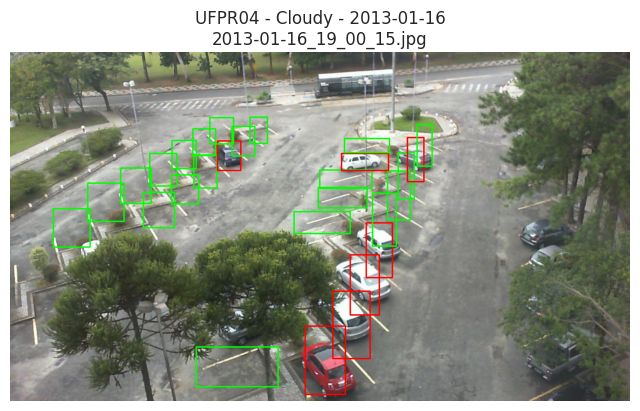

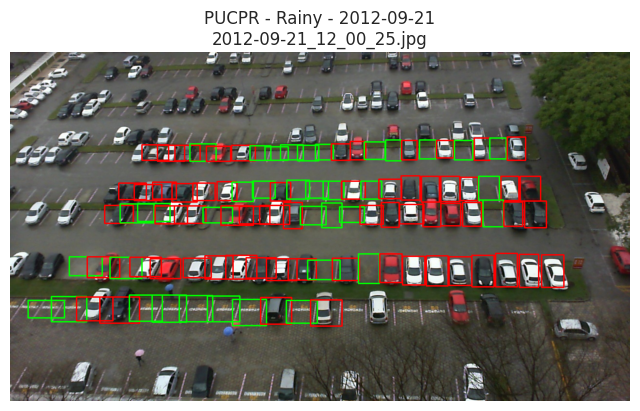

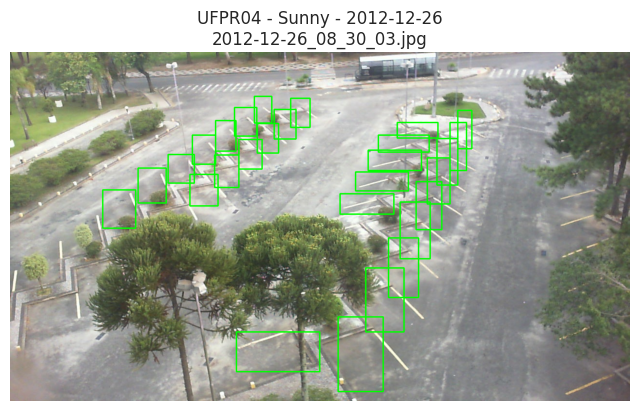

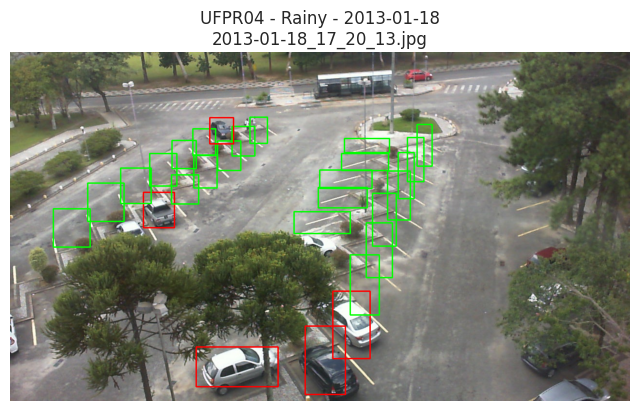

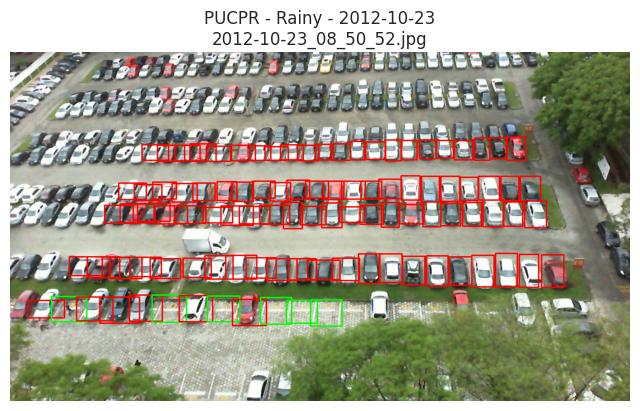

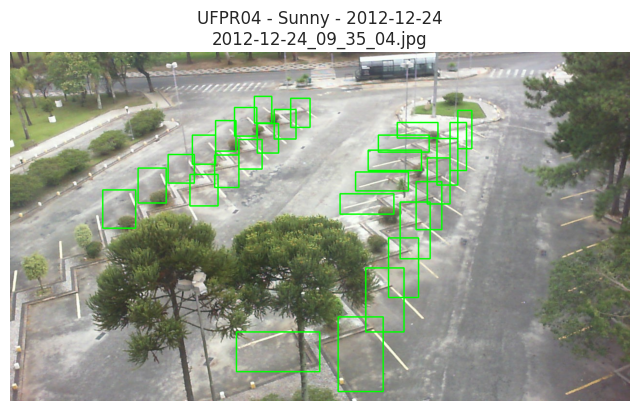

In [6]:
# ============================================================
# Visualize Random Original PKLot Scene Images + XML Boxes
# ============================================================

import random
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import cv2
from pathlib import Path

def load_xml_boxes(xml_path):
    """
    Parse PKLot XML annotation (format with nested center/size/angle tags)
    and return list of axis-aligned bounding boxes plus occupancy flag.
    """
    boxes = []

    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()

        for space in root.findall(".//space"):
            occupied = int(space.get("occupied", 0))

            rect = space.find("rotatedRect")
            if rect is None:
                continue

            # ---- New PKLot XML format ----
            center = rect.find("center")
            size   = rect.find("size")
            angle  = rect.find("angle")

            # Parse center
            if center is not None and size is not None:
                cx = float(center.get("x"))
                cy = float(center.get("y"))
                w  = float(size.get("w"))
                h  = float(size.get("h"))

            else:
                # ---- Old PKLot XML format fallback ----
                # <rotatedRect cx="" cy="" w="" h="" angle=""/>
                cx = float(rect.get("cx"))
                cy = float(rect.get("cy"))
                w  = float(rect.get("w"))
                h  = float(rect.get("h"))

            # Compute axis-aligned bounding box
            x1 = int(cx - w / 2)
            y1 = int(cy - h / 2)
            x2 = int(cx + w / 2)
            y2 = int(cy + h / 2)

            boxes.append((x1, y1, x2, y2, occupied))

    except Exception as e:
        print("Error parsing XML:", xml_path, e)

    return boxes

# ------------------------------------------------------------
# Pick 6 random scene-level samples
# ------------------------------------------------------------
num_samples = 6
sample_indices = random.sample(range(len(df)), num_samples)
samples = df.iloc[sample_indices]

for idx, row in samples.iterrows():
    campus = row["campus"]
    weather = row["weather"]
    date = row["date"]

    # Folder with JPG + XML files
    folder = PKLOT_ORIG / campus / weather / date

    # Load ONE random image from this date
    jpgs = sorted(folder.glob("*.jpg"))
    if not jpgs:
        print("No images found in:", folder)
        continue

    img_path = random.choice(jpgs)
    xml_path = img_path.with_suffix(".xml")

    # Load image
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Load bounding boxes
    boxes = load_xml_boxes(xml_path)

    # Draw boxes
    for (x1, y1, x2, y2, occ) in boxes:
        color = (255,0,0) if occ == 1 else (0,255,0)
        cv2.rectangle(img_rgb, (x1,y1), (x2,y2), color, 2)

    # Show
    plt.figure(figsize=(8,6))
    plt.imshow(img_rgb)
    plt.title(f"{campus} - {weather} - {date}\n{img_path.name}")
    plt.axis("off")
    plt.show()
